In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#raw_data = spark.read.format("csv").option("header","true").option("inferSchema", "true").load(r".\\diabetes.csv")
dataset = spark.read.csv('/content/titanic_synthetic_data.csv',inferSchema=True, header =True)

In [ ]:
# what are the columns in this dataset
dataset.columns

['Pclass',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Sex',
 'Survived',
 'Embarked_Q',
 'Embarked_S']

In [ ]:
dataset.describe().select("Summary","Age","Sibsp","Fare","Sex").show()

+-------+-----------------+-----------------+------------------+------------------+
|Summary|              Age|            Sibsp|              Fare|               Sex|
+-------+-----------------+-----------------+------------------+------------------+
|  count|           445357|           445357|            445357|            445357|
|   mean|39.52557162007109| 4.50394851770602|254.90930440444185|0.5013708103835799|
| stddev|23.10318964326725|2.872431925258139|141.53941771519837|0.4999986822216082|
|    min|                0|                0|10.000669172033327|                 0|
|    max|               79|                9| 499.9986859874771|                 1|
+-------+-----------------+-----------------+------------------+------------------+



In [ ]:
dataset.describe().select("Parch","Embarked_S","Embarked_Q").show()

+------------------+-------------------+------------------+
|             Parch|         Embarked_S|        Embarked_Q|
+------------------+-------------------+------------------+
|            445357|             445357|            445357|
| 4.499886607822488|0.33412296202821556|0.3326769310912369|
|2.8738077632596637| 0.4716834826871893|0.4711724621572146|
|                 0|                  0|                 0|
|                 9|                  1|                 1|
+------------------+-------------------+------------------+



In [ ]:
dataset.describe().select("Pclass").show()

+------------------+
|            Pclass|
+------------------+
|            445357|
|1.9987156371180872|
|0.8165808175227187|
|                 1|
|                 3|
+------------------+



In [ ]:
from pyspark.sql.functions import col,isnan, when, count
dataset.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in dataset.columns]
   ).show()

+------+---+-----+-----+----+---+--------+----------+----------+
|Pclass|Age|SibSp|Parch|Fare|Sex|Survived|Embarked_Q|Embarked_S|
+------+---+-----+-----+----+---+--------+----------+----------+
|     0|  0|    0|    0|   0|  0|       0|         0|         0|
+------+---+-----+-----+----+---+--------+----------+----------+



In [ ]:
# replace min value of zeros with None as data cleaning processs
import numpy as np
from pyspark.sql.functions import when
dataset=dataset.withColumn("SibSp",when(dataset.SibSp==0, None).otherwise (dataset.SibSp)) # Corrected typo
dataset=dataset.withColumn("Fare",when(dataset.Fare==0,None).otherwise(dataset.Fare))
dataset=dataset.withColumn("Age",when(dataset.Age==0,None).otherwise(dataset.Age))
dataset=dataset.withColumn("Parch",when(dataset.Parch==0,None).otherwise(dataset.Parch))
dataset=dataset.withColumn("Pclass",when(dataset.Pclass==0,None).otherwise(dataset.Pclass))
dataset.select("Pclass","Parch","Age","Fare","SibSp").show(5)

+------+-----+---+------------------+-----+
|Pclass|Parch|Age|              Fare|SibSp|
+------+-----+---+------------------+-----+
|     3|    7| 42|397.00178367782024|    6|
|     1|    7| 52|302.12770032784186|    6|
|     3|    8| 25| 427.1058765283985|    3|
|     3|    7| 32| 326.8049924602327|    9|
|     1|    5| 40|17.718838497771657| NULL|
+------+-----+---+------------------+-----+
only showing top 5 rows



In [ ]:
# check again NAN values
from pyspark.sql.functions import col,isnan, when, count
dataset.select([count(when(isnan(c) , c)).alias(c) for c in dataset.columns]
   ).show()

+------+---+-----+-----+----+---+--------+----------+----------+
|Pclass|Age|SibSp|Parch|Fare|Sex|Survived|Embarked_Q|Embarked_S|
+------+---+-----+-----+----+---+--------+----------+----------+
|     0|  0|    0|    0|   0|  0|       0|         0|         0|
+------+---+-----+-----+----+---+--------+----------+----------+



In [ ]:
#impute
from pyspark.ml.feature import Imputer
imputer=Imputer(inputCols=["SibSp","Fare","Age","Parch"],outputCols=["SibSp","Fare","Age","Parch"])
model=imputer.fit(dataset)
dataset=model.transform(dataset)
dataset.show(5)

+------+---+-----+-----+------------------+---+--------+----------+----------+
|Pclass|Age|SibSp|Parch|              Fare|Sex|Survived|Embarked_Q|Embarked_S|
+------+---+-----+-----+------------------+---+--------+----------+----------+
|     3| 42|    6|    7|397.00178367782024|  0|       0|         0|         1|
|     1| 52|    6|    7|302.12770032784186|  0|       0|         1|         0|
|     3| 25|    3|    8| 427.1058765283985|  1|       1|         1|         0|
|     3| 32|    9|    7| 326.8049924602327|  1|       0|         0|         0|
|     1| 40|    5|    5|17.718838497771657|  0|       0|         0|         0|
+------+---+-----+-----+------------------+---+--------+----------+----------+
only showing top 5 rows



In [ ]:
#us combine all the features in one single feature vector.
cols=dataset.columns
cols.remove("Survived")
cols.remove("Fare")
# Let us import the vector assembler
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=cols,outputCol="features")
# Now let us use the transform method to transform our dataset
dataset=assembler.transform(dataset)
dataset.select("features").show(truncate=False)


+------------------------------+
|features                      |
+------------------------------+
|[3.0,42.0,6.0,7.0,0.0,0.0,1.0]|
|[1.0,52.0,6.0,7.0,0.0,1.0,0.0]|
|[3.0,25.0,3.0,8.0,1.0,1.0,0.0]|
|[3.0,32.0,9.0,7.0,1.0,0.0,0.0]|
|[1.0,40.0,5.0,5.0,0.0,0.0,0.0]|
|[1.0,20.0,7.0,2.0,0.0,0.0,0.0]|
|[3.0,76.0,4.0,9.0,0.0,1.0,0.0]|
|[2.0,22.0,4.0,7.0,1.0,0.0,0.0]|
|[3.0,78.0,4.0,8.0,1.0,0.0,0.0]|
|[3.0,15.0,1.0,8.0,1.0,1.0,0.0]|
|[3.0,68.0,8.0,7.0,1.0,0.0,1.0]|
|[3.0,3.0,7.0,1.0,0.0,1.0,0.0] |
|[1.0,63.0,4.0,5.0,1.0,0.0,0.0]|
|[3.0,40.0,9.0,8.0,0.0,0.0,1.0]|
|[2.0,62.0,3.0,4.0,1.0,0.0,0.0]|
|[1.0,41.0,2.0,8.0,1.0,0.0,1.0]|
|[2.0,40.0,4.0,2.0,1.0,0.0,1.0]|
|[2.0,64.0,5.0,4.0,0.0,0.0,1.0]|
|[2.0,67.0,3.0,6.0,0.0,0.0,0.0]|
|[2.0,35.0,5.0,1.0,1.0,0.0,0.0]|
+------------------------------+
only showing top 20 rows



In [ ]:
#Standard Sclarizer
from pyspark.ml.feature import StandardScaler
standardscaler=StandardScaler().setInputCol("features").setOutputCol("Scaled_features")
dataset=standardscaler.fit(dataset).transform(dataset)
dataset.select("features","Scaled_features").show(5)


+--------------------+--------------------+
|            features|     Scaled_features|
+--------------------+--------------------+
|[3.0,42.0,6.0,7.0...|[3.67385558860073...|
|[1.0,52.0,6.0,7.0...|[1.22461852953357...|
|[3.0,25.0,3.0,8.0...|[3.67385558860073...|
|[3.0,32.0,9.0,7.0...|[3.67385558860073...|
|[1.0,40.0,5.0,5.0...|[1.22461852953357...|
+--------------------+--------------------+
only showing top 5 rows



In [ ]:
dataset.show(5,truncate=False)

+------+---+-----+-----+------------------+---+--------+----------+----------+------------------------------+----------------------------------------------------------------------------------------------------------------------+
|Pclass|Age|SibSp|Parch|Fare              |Sex|Survived|Embarked_Q|Embarked_S|features                      |Scaled_features                                                                                                       |
+------+---+-----+-----+------------------+---+--------+----------+----------+------------------------------+----------------------------------------------------------------------------------------------------------------------+
|3     |42 |6    |7    |397.00178367782024|0  |0       |0         |1         |[3.0,42.0,6.0,7.0,0.0,0.0,1.0]|[3.6738555886007385,1.852230251240257,2.4475793068162948,2.8578339428819723,0.0,0.0,2.120065757450278]                |
|1     |52 |6    |7    |302.12770032784186|0  |0       |1         |0         |[1.0,5

In [ ]:
#Train, test split
train, test = dataset.randomSplit([0.8, 0.2], seed=12345)

In [ ]:
#imbalance in the dataset, observe the use of Where
dataset_size=float(train.select("Survived").count())
numPositives=train.select("Survived").where('Survived == 1').count()
per_ones=(float(numPositives)/float(dataset_size))*100
numNegatives=float(dataset_size-numPositives)
print('The number of ones are {}'.format(numPositives))
print('Percentage of ones are {}'.format(per_ones))

The number of ones are 178610
Percentage of ones are 50.13079306628345


In [ ]:
BalancingRatio= numNegatives/dataset_size
print('BalancingRatio = {}'.format(BalancingRatio))

BalancingRatio = 0.4986920693371654


In [ ]:
# balance
train=train.withColumn("classWeights", when(train.Survived == 1,BalancingRatio).otherwise(1-BalancingRatio))
train.select("classWeights").show(5)

+------------------+
|      classWeights|
+------------------+
|0.4986920693371654|
|0.4986920693371654|
|0.4986920693371654|
|0.5013079306628345|
|0.5013079306628345|
+------------------+
only showing top 5 rows



In [ ]:
#Feature selection
# Feature selection using chisquareSelector
from pyspark.ml.feature import ChiSqSelector
css = ChiSqSelector(featuresCol='Scaled_features',outputCol='Aspect',labelCol='Survived',fpr=0.05)
train=css.fit(train).transform(train)
test=css.fit(test).transform(test)
test.select("Aspect").show(5,truncate=False)

+------------------------------------------------------------------------------------------------------------------------+
|Aspect                                                                                                                  |
+------------------------------------------------------------------------------------------------------------------------+
|[1.2246185295335794,0.04410072026762517,0.40792988446938244,0.4082619918402818,2.0000052711274514,0.0,2.120065757450278]|
|[1.2246185295335794,0.04410072026762517,0.40792988446938244,0.8165239836805636,0.0,0.0,0.0]                             |
|[1.2246185295335794,0.04410072026762517,0.40792988446938244,1.2247859755208452,0.0,0.0,2.120065757450278]               |
|[1.2246185295335794,0.04410072026762517,0.40792988446938244,1.2247859755208452,0.0,0.0,0.0]                             |
|[1.2246185295335794,0.04410072026762517,0.40792988446938244,1.2247859755208452,0.0,0.0,2.120065757450278]               |
+---------------

In [ ]:
train.show()

+------+---+-----+-----+------------------+---+--------+----------+----------+--------------------+--------------------+------------------+--------------------+
|Pclass|Age|SibSp|Parch|              Fare|Sex|Survived|Embarked_Q|Embarked_S|            features|     Scaled_features|      classWeights|              Aspect|
+------+---+-----+-----+------------------+---+--------+----------+----------+--------------------+--------------------+------------------+--------------------+
|     1|  1|    1|    1|28.811477212867022|  0|       1|         0|         0|[1.0,1.0,1.0,1.0,...|[1.22461852953357...|0.4986920693371654|[1.22461852953357...|
|     1|  1|    1|    1| 98.03437973491282|  1|       1|         0|         0|[1.0,1.0,1.0,1.0,...|[1.22461852953357...|0.4986920693371654|[1.22461852953357...|
|     1|  1|    1|    1|  156.489934014647|  0|       1|         0|         1|[1.0,1.0,1.0,1.0,...|[1.22461852953357...|0.4986920693371654|[1.22461852953357...|
|     1|  1|    1|    1|229.552107

In [ ]:
train.select("Parch").distinct().show()


+-----+
|Parch|
+-----+
|    1|
|    6|
|    3|
|    5|
|    9|
|    4|
|    8|
|    7|
|    2|
+-----+



In [ ]:
#Building a classification model using Logistic Regression (LR)
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol="Survived", featuresCol="Aspect",weightCol="classWeights",maxIter=10)
model=lr.fit(train)
predict_train=model.transform(train)
predict_test=model.transform(test)
predict_test.select("Survived","prediction").show(10)

+--------+----------+
|Survived|prediction|
+--------+----------+
|       0|       0.0|
|       0|       0.0|
|       1|       0.0|
|       1|       0.0|
|       0|       0.0|
|       1|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
+--------+----------+
only showing top 10 rows



In [ ]:
#Evaluating the model
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator=BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol="Survived")
# We have only two choices: area under ROC and PR curves :-(
auroc = evaluator.evaluate(predict_test, {evaluator.metricName: "areaUnderROC"})

print("Area under ROC Curve: {:.4f}".format(auroc))

predict_test.select("Survived","prediction","probability").show(15)

Area under ROC Curve: 0.4980
+--------+----------+--------------------+
|Survived|prediction|         probability|
+--------+----------+--------------------+
|       0|       0.0|[0.50217433189783...|
|       0|       0.0|[0.50435201287487...|
|       1|       0.0|[0.50377034330040...|
|       1|       0.0|[0.50441855171425...|
|       0|       0.0|[0.50377034330040...|
|       1|       0.0|[0.50237395964008...|
|       0|       0.0|[0.50237395964008...|
|       0|       0.0|[0.50308873412147...|
|       0|       0.0|[0.50468470548306...|
|       0|       0.0|[0.50322181673716...|
|       0|       0.0|[0.50468470548306...|
|       0|       0.0|[0.50410304245387...|
|       1|       0.0|[0.50475124351630...|
|       1|       0.0|[0.50410304245387...|
|       1|       0.0|[0.50335489889635...|
+--------+----------+--------------------+
only showing top 15 rows



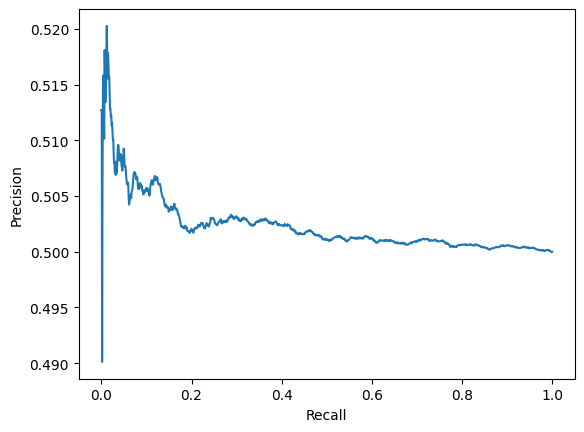

Model Accuracy 0.5010455012870654
FP rate [0.49949051004982925, 0.4984184873760398]
TR rate [0.5015815126239601, 0.5005094899501709]


In [ ]:
print(model.summary)
import matplotlib.pyplot as plt
pr = model.summary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()
print("Model Accuracy",model.summary.accuracy)
print("FP rate",model.summary.falsePositiveRateByLabel)
print("TR rate",model.summary.truePositiveRateByLabel)

In [ ]:
#print("Total True Positive i.e. diabetes",predict_test.select("Outcome").where('Outcome == 1.0').count())
#print("Total True  Negative,i.e. without diabetes",predict_test.select("Outcome").where('Outcome == 0.0').count())
pr = predict_test.toPandas()
TruePositive =0
FalsePositive=0
TrueNegative=0
FalseNegative=0
Postive=1.0
Negative=0.0
pos=0
Neg=0

print("Total",len(pr["Survived"]))
for lbl in range(len(pr["Survived"])):
  if  pr["prediction"][lbl]==Postive:
    pos+=1
    if pr["prediction"][lbl]==pr["Survived"][lbl]:
      TruePositive+=1
    else:
      FalsePositive+=1
  if  pr["prediction"][lbl]==Negative:
    Neg+=1
    if pr["prediction"][lbl]==pr["Survived"][lbl]:
      TrueNegative+=1
    else:
      FalseNegative+=1
#print("Total Positive & Negative predicted,  Survived: ",pos,",Non Survided",Neg)
print("TruePostive",TruePositive,"FalsePostive",FalsePositive)
print("TrueNegative",TrueNegative,"FalseNegative",FalseNegative)

Total 89069
TruePostive 22106 FalsePostive 22469
TrueNegative 22250 FalseNegative 22244


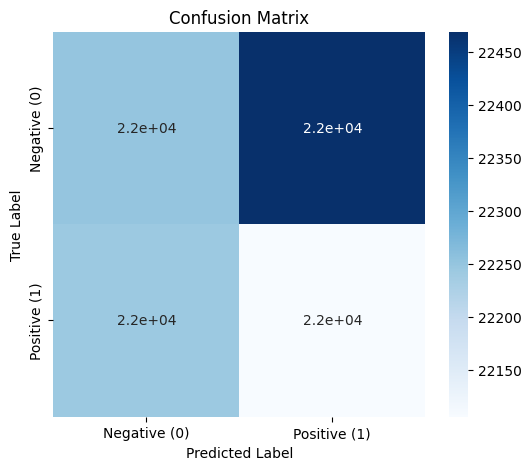

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

TN = TrueNegative
FP = FalsePositive
FN = FalseNegative
TP = TruePositive
conf_matrix = np.array([[TN, FP],
                        [FN, TP]])
labels = ["Negative (0)", "Positive (1)"]

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True,  cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()